In [1]:

!pip install librosa==0.9.2 audiomentations==0.24.0 soundfile --quiet


In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("orvile/ravdess-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ravdess-dataset' dataset.
Path to dataset files: /kaggle/input/ravdess-dataset


In [3]:
import os
import glob
import pandas as pd
# We will work on audio speech actors only for now
files = glob.glob(path+ '/Audio_Speech_Actors_01-24' + '/**/*.wav', recursive=True)
print("Total files found:", len(files))
print("Example:", files[0])


Total files found: 1440
Example: /kaggle/input/ravdess-dataset/Audio_Speech_Actors_01-24/Actor_02/03-01-08-01-01-01-02.wav


In [4]:
def parse_ravdess_filename(filename):
    parts = os.path.basename(filename).split('.')[0].split('-')

    info = {
        "path": filename,
        "modality": {"01": "full-AV", "02": "video-only", "03": "audio-only"}[parts[0]],
        "vocal_channel": {"01": "speech", "02": "song"}[parts[1]],
        "emotion": {
            "01": "neutral",
            "02": "calm",
            "03": "happy",
            "04": "sad",
            "05": "angry",
            "06": "fearful",
            "07": "disgust",
            "08": "surprised"
        }[parts[2]],
        "intensity": {"01": "normal", "02": "strong"}[parts[3]],
        "statement": {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"}[parts[4]],
        "repetition": {"01": "1st", "02": "2nd"}[parts[5]],
        "actor": int(parts[6]),
    }
    info["gender"] = "male" if info["actor"] % 2 != 0 else "female"
    return info


In [5]:
data = [parse_ravdess_filename(f) for f in files]
df = pd.DataFrame(data)
df.head()


,path,modality,vocal_channel,emotion,intensity,statement,repetition,actor,gender
0,/kaggle/input/ravdess-dataset/Audio_Speech_Act...,audio-only,speech,surprised,normal,Kids are talking by the door,1st,2,female
1,/kaggle/input/ravdess-dataset/Audio_Speech_Act...,audio-only,speech,neutral,normal,Kids are talking by the door,1st,2,female
2,/kaggle/input/ravdess-dataset/Audio_Speech_Act...,audio-only,speech,disgust,strong,Kids are talking by the door,2nd,2,female
3,/kaggle/input/ravdess-dataset/Audio_Speech_Act...,audio-only,speech,disgust,normal,Kids are talking by the door,2nd,2,female
4,/kaggle/input/ravdess-dataset/Audio_Speech_Act...,audio-only,speech,neutral,normal,Dogs are sitting by the door,1st,2,female


In [6]:
print(df["emotion"].value_counts())
print(df.groupby("gender")["emotion"].value_counts())


emotion
surprised    192
disgust      192
fearful      192
sad          192
happy        192
calm         192
angry        192
neutral       96
Name: count, dtype: int64
gender  emotion  
female  angry        96
        calm         96
        disgust      96
        fearful      96
        happy        96
        sad          96
        surprised    96
        neutral      48
male    angry        96
        calm         96
        disgust      96
        fearful      96
        happy        96
        sad          96
        surprised    96
        neutral      48
Name: count, dtype: int64


In [7]:
import librosa
import numpy as np

SR = 16000      # sample rate
DURATION = 3.0  # seconds
SAMPLES = int(SR * DURATION)

def preprocess_audio(path, sr=SR):
    y, orig_sr = librosa.load(path, sr=None)
    if y.ndim > 1:
        y = np.mean(y, axis=1)  # to mono
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr, sr)
    y, _ = librosa.effects.trim(y, top_db=20)
    y = y / (np.max(np.abs(y)) + 1e-6)
    if len(y) < SAMPLES:
        pad = SAMPLES - len(y)
        y = np.pad(y, (0, pad))
    else:
        y = y[:SAMPLES]
    return y


In [8]:
def to_log_mel(y, sr=SR, n_mels=128):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # normalize per-sample
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9)
    return mel_db


/tmp/ipython-input-2876888510.py:13: FutureWarning: Pass orig_sr=48000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.resample(y, orig_sr, sr)


Spec shape: (128, 94)


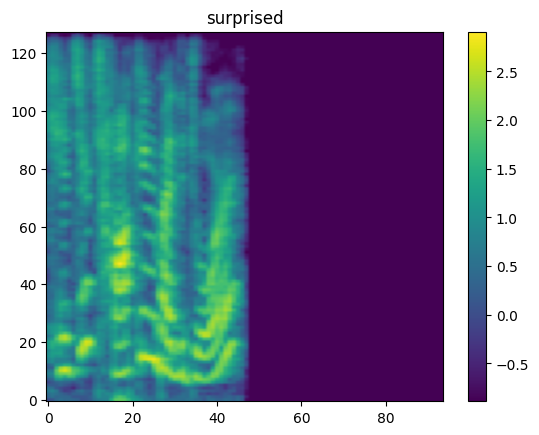

In [9]:
import matplotlib.pyplot as plt

y = preprocess_audio(df["path"].iloc[0])
spec = to_log_mel(y)
print("Spec shape:", spec.shape)

plt.imshow(spec, aspect="auto", origin="lower")
plt.title(df["emotion"].iloc[0])
plt.colorbar()
plt.show()


In [10]:
X = []
y_labels = []

for i, row in df.iterrows():
    y = preprocess_audio(row["path"])
    spec = to_log_mel(y)
    X.append(spec)
    y_labels.append(row["emotion"])

X = np.array(X)
print("Shape:", X.shape)

/tmp/ipython-input-2876888510.py:13: FutureWarning: Pass orig_sr=48000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.resample(y, orig_sr, sr)


Shape: (1440, 128, 94)


In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_labels)

print("Classes:", encoder.classes_)


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [12]:
from google.colab import drive
drive.mount('/content/drive')

np.save("/content/drive/MyDrive/RAVDESS/X_speech.npy", X)
np.save("/content/drive/MyDrive/RAVDESS/y_speech.npy", y_encoded)
np.save("/content/drive/MyDrive/RAVDESS/classes.npy", encoder.classes_)

# X = np.load("/content/drive/MyDrive/RAVDESS/X_speech.npy")
# y = np.load("/content/drive/MyDrive/RAVDESS/y_speech.npy")
# classes = np.load("/content/drive/MyDrive/RAVDESS/classes.npy")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# CNNs expect shape (samples, height, width, channels)
X = np.expand_dims(X, -1)

print("X shape:", X.shape)
print("y shape:", y_encoded.shape)
print("Emotions:", encoder.classes_)


X shape: (1440, 128, 94, 1)
y shape: (1440,)
Emotions: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
